In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

import catboost as catb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Построение модели классификации

### 1. Обзор обучающего датасета


#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_project/'
TRAIN_DATASET_PATH = PATH + 'course_project_train.csv'
TEST_DATASET_PATH = PATH + 'course_project_test.csv'
PREP_DATASET_PATH = PATH + 'course_project_prep_train.csv'

### 2. Загрузка данных

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [5]:
TARGET_NAME = 'Credit Default'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (7500, 16)
y.shape =  (7500,)


In [6]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [7]:
X_final = pd.read_csv(TEST_DATASET_PATH)
print('X_final.shape', X_final.shape)
X_final.head(2)

X_final.shape (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


### 3. Обработка пропусков и выбросов

* Пропуски в 'Credit Score' заполнены медианой.
* 'Years in current job' трансформированы в числовые значения от 0 до 10, пропуски заполнены медианой.
* Пропуски в 'Bankruptcies' заполнены 1, где 'Number of Credit Problems' > 0  и 0, где 'Number of Credit Problems' = 0.
* Пропуски в 'Annual Income' заполнены медианнами 30 групп, сформированных через ранжирование 'Monthly Debt'.
* В 'Current Loan Amount' значения 99999999 заполнены медианнами 30 групп, сформированных через ранжирование 'Monthly Debt'.
* В 'Maximum Open Credit' значения > 3 * 1e6 заполнены медианнами 30 групп, сформированных через ранжирование 'Current Credit Balance'.
* В 'Current Credit Balance' значения > 1.5 * 1e6 заполнены медианнами 30 групп, сформированных через ранжирование 'Maximum Open Credit'.
* Признак 'Months since last delinquent' удален, поскольку в нем больше половины пропусков.

In [8]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.years = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                      '6 years', '7 years',  '8 years', '9 years', '10+ years']
        
        self.n_groups = 30        
        self.med_credit_score = None
        self.med_years_in_current_job = None
        self.med_annual_income = None
        self.med_current_loan_amount = None        
        self.med_maximum_open_credit = None
        self.med_current_credit_balance = None       
        
        
    def fit(self, X):
        
        df = X.copy()
        
        # Credit Score
        self.med_credit_score = df['Credit Score'].median()        
        
        # Years in current job            
        for i in range(len(self.years)):
            df.loc[df['Years in current job']==self.years[i],'Years in current job'] = i
               
        self.med_years_in_current_job = df['Years in current job'].median()        
        
        # Annual Income, Current Loan Amount, Maximum Open Credit, Current Credit Balance 
        t = df.shape[0] / self.n_groups
        df['monthly_debt_group'] = np.floor(ss.rankdata(df['Monthly Debt'].values) / t)
        df['current_credit_balance_group'] = np.floor(ss.rankdata(df['Current Credit Balance'].values) / t)
        df['maximum_open_credit_group'] = np.floor(ss.rankdata(df['Maximum Open Credit'].values) / t)
        
        self.med_annual_income = df.groupby(['monthly_debt_group'], 
                                            as_index=False).agg({'Annual Income':'median'})
        self.med_current_loan_amount = df.groupby(['monthly_debt_group'],
                                                 as_index=False).agg({'Current Loan Amount':'median'})
        self.med_maximum_open_credit = df.groupby(['current_credit_balance_group'],
                                                 as_index=False).agg({'Maximum Open Credit':'median'}) 
        self.med_current_credit_balance = df.groupby(['maximum_open_credit_group'],
                                                    as_index=False).agg({'Current Credit Balance':'median'})

    
    def transform(self, X):
        # 1.Credit Score
        X.loc[X['Credit Score']>1000, 'Credit Score'] /= 10
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.med_credit_score
        
        # 2.Years in current job
        for i in range(len(self.years)):
            X.loc[X['Years in current job']==self.years[i],'Years in current job'] = i        
        
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.med_years_in_current_job
        X['Years in current job'] = X['Years in current job'].astype(int)
        
        # 3.Bankruptcies
        X.loc[X['Bankruptcies'].isna() & (X['Number of Credit Problems'] == 0), 'Bankruptcies'] = 0
        X.loc[X['Bankruptcies'].isna() & (X['Number of Credit Problems'] > 0), 'Bankruptcies'] = 1        
     
        
        # 4.Annual Income
        t0 = 0
        for i in range(self.n_groups):
            cond1 = X['Annual Income'].isna()
            if i != self.n_groups - 1:
                t1 = (self.med_annual_income.loc[i, 'Annual Income'] +\
                      self.med_annual_income.loc[i+1, 'Annual Income']) / 2 
                cond2 = (X['Monthly Debt'] >= t0) & (X['Monthly Debt'] < t1)
            else:
                cond2 = (X['Monthly Debt'] >= t0)
            X.loc[cond1 & cond2, 'Annual Income'] = self.med_annual_income.loc[i, 'Annual Income']
            t0 = t1
        
        # 5.Current Loan Amount
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Current Loan Amount'] == 99999999)
            if i != self.n_groups - 1:
                t1 = (self.med_current_loan_amount.loc[i, 'Current Loan Amount'] +\
                      self.med_current_loan_amount.loc[i+1, 'Current Loan Amount']) / 2 
                cond2 = (X['Monthly Debt'] >= t0) & (X['Monthly Debt'] < t1)
            else:
                cond2 = (X['Monthly Debt'] >= t0)
            X.loc[cond1 & cond2, 'Current Loan Amount'] = self.med_current_loan_amount.loc[i, 'Current Loan Amount']
            t0 = t1        
        
        # 6.Maximum Open Credit
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Maximum Open Credit'] > 3 * 1e6)
            if i != self.n_groups - 1:
                t1 = (self.med_maximum_open_credit.loc[i, 'Maximum Open Credit'] +\
                      self.med_maximum_open_credit.loc[i+1, 'Maximum Open Credit']) / 2 
                cond2 = (X['Current Credit Balance'] >= t0) & (X['Current Credit Balance'] < t1)
            else:
                cond2 = (X['Current Credit Balance'] >= t0)
            X.loc[cond1 & cond2, 'Maximum Open Credit'] = self.med_maximum_open_credit.loc[i, 'Maximum Open Credit']
            t0 = t1        
        
        # 7.Current Credit Balance
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Current Credit Balance'] > 1.5 * 1e6)
            if i != self.n_groups - 1:
                t1 = (self.med_current_credit_balance.loc[i, 'Current Credit Balance'] +\
                      self.med_current_credit_balance.loc[i+1, 'Current Credit Balance']) / 2 
                cond2 = (X['Maximum Open Credit'] >= t0) & (X['Maximum Open Credit'] < t1)
            else:
                cond2 = (X['Maximum Open Credit'] >= t0)
            X.loc[cond1 & cond2, 'Current Credit Balance'] = self.med_current_credit_balance.loc[i, 'Current Credit Balance']
            t0 = t1
            
        # 9.Months since last delinquen    
        X = X.drop('Months since last delinquent', axis=1)
        #X['Months since last delinquent'] = X['Months since last delinquent'].fillna(0)
               
        return X

In [9]:
features = FeatureImputer()
features.fit(X)
X = features.transform(X)
X_final = features.transform(X_final)

In [10]:
len(X_final) - X_final.count()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

### 4. Анализ данных


In [11]:
NUMERIC_FEATURE_NAMES = [ 'Annual Income', 'Years in current job', 'Tax Liens','Number of Open Accounts',
                         'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                         'Credit Score']

CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

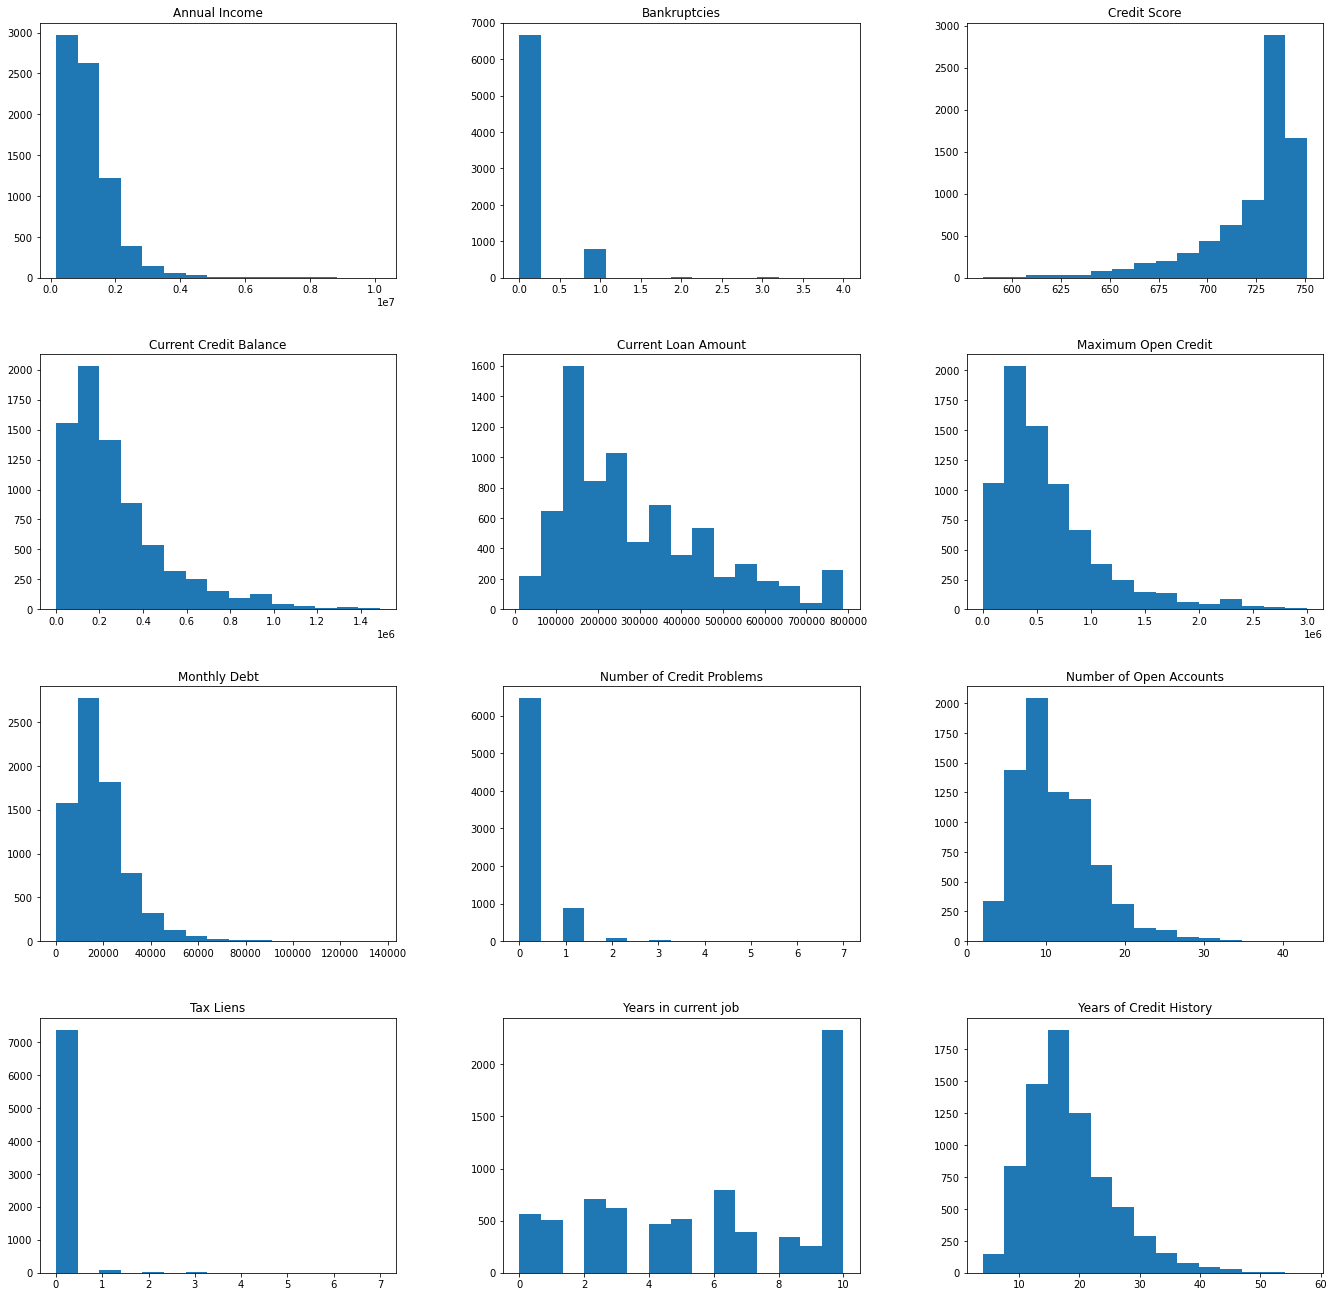

In [12]:
X.loc[:, NUMERIC_FEATURE_NAMES].hist(figsize=(23,23), bins=15, grid=False);

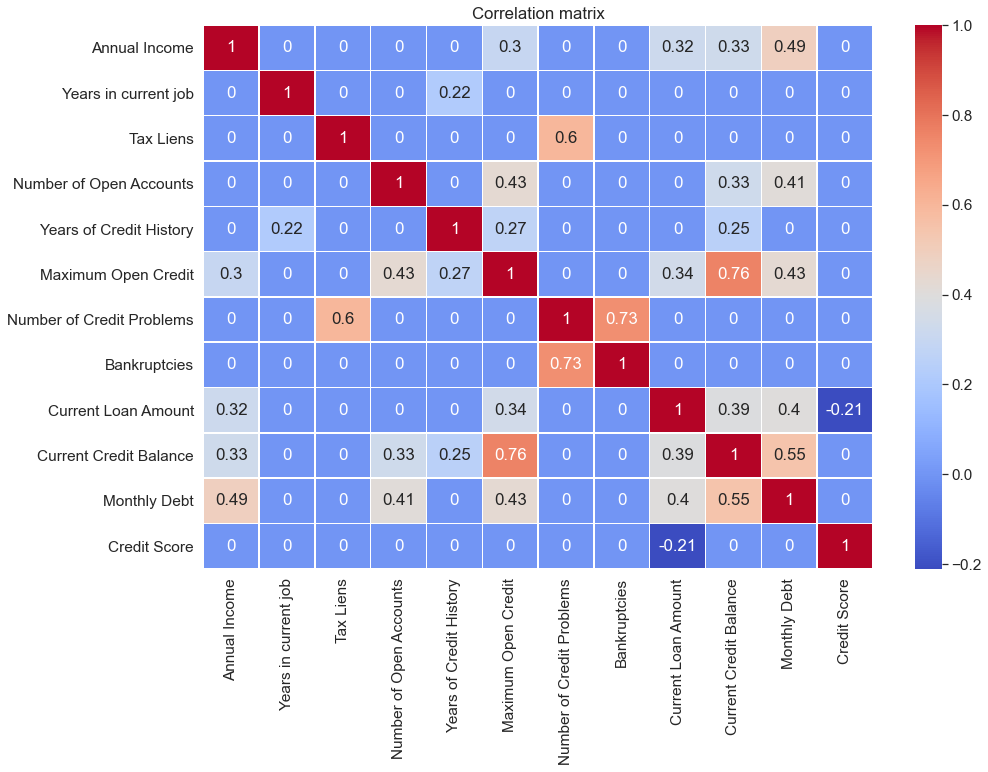

In [13]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X[NUMERIC_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.20] = 0  # убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Доля дисперсии, объясненная соответствующими компонентами: [0.26686584 0.16614957 0.09886553 0.08941091 0.07894754]



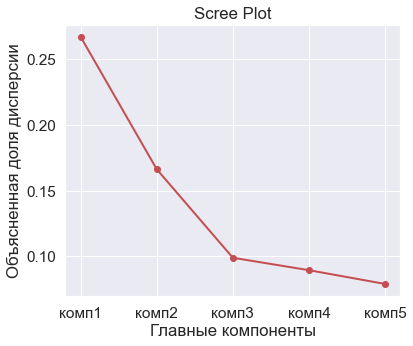



Первые 4 компонента объясяют 0.62129 дисперсии



In [14]:
scaler = StandardScaler()

a = X[NUMERIC_FEATURE_NAMES]

a = scaler.fit_transform(a)        
pca = PCA(n_components=5)
pca.fit(a)
print(f'Доля дисперсии, объясненная соответствующими компонентами: {pca.explained_variance_ratio_}\n')

fig = plt.figure(figsize=(6,5))
plt.plot(['комп1','комп2','комп3','комп4', 'комп5'], pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Главные компоненты')
plt.ylabel('Объясненная доля дисперсии')
plt.show()

print('\n')
print(f'Первые 4 компонента объясяют {round(pca.explained_variance_ratio_[:4].sum(), 5)} дисперсии\n')

### 5. Построение новых признаков

* Из признаков Bankruptcies, Tax Liens и Number of Credit Problems методом target encoding генерируется Composit_1. 
* Из признаков Home Ownership и Purpose методом target encoding генерируется Composit_2, причем в каждом из признаков используются только значения  с частотой выше 25.
* Из признаков Current Loan Amount и Credit Score методом target encoding генерируется Composit_3.  Current Loan Amount разбивается на группы с шагом 30 тыс.руб., Credit Score - на группы с шагом 25 баллов.
* Из признаков Annual Income и Credit Score методом target encoding генерируется Composit_4. Annual Income разбивается на группы с шагом 100 тыс.руб. Испельзуются только группы, в которые попали более 30 клиентов.
* Из признаков Current Loan Amount и Maximum Open Credit  методом target encoding генерируется Composit_5. Current Loan Amount разбивается на группы с шагом 100 тыс.руб., Maximum Open Credit - с шагом 200 тыс.руб. В Maximum Open Credit используются только группы, в которые попали более 30 клиентов.
* Из признаков Monthly Debt и Maximum Open Credit  методом target encoding генерируется Composit_6. Monthly Debt разбивается на группы с шагом 10 тыс.руб, используются только группы, в которые попали более 30 клиентов. Maximum Open Credit используется также, как в Composit_5.
* Из признаков Number of Open Accounts и Years of Credit History  методом target encoding генерируется Composit_7. Группы формируются с шагом 3 счета и 3 года соответственно. Используютсяя тольько группы с числом клиентов больше 30.
* Категориальный признак Term трансформируется в бинарный признак (0 - 'Short Term', 1 - 'Long Term')
* Из числовых признаков методом главных компонент (PCA) формируются 4 новых признака: pca_composit_1, pca_composit_2, pca_composit_3 и pca_composit_4  

In [15]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):        
        self.mean_default_by_composit_1 = None
        self.mean_default_by_composit_2 = None
        self.mean_default_by_composit_3 = None
        self.mean_default_by_composit_4 = None
        self.mean_default_by_composit_5 = None
        self.mean_default_by_composit_6 = None
        self.mean_default_by_composit_7 = None        
        
    
    def fit(self, X, y=None):
        X = X.copy()
        
        # Purpose
        purpose = X['Purpose'].value_counts()
        purpose = purpose[purpose > 25] 
        
        # Home Ownership
        home_ownership = X['Home Ownership'].value_counts()
        home_ownership = home_ownership[home_ownership > 25]
        
        # Annual Income group
        annual_income_group = (X['Annual Income'] / 1e5).round(0).value_counts()
        annual_income_group = annual_income_group[annual_income_group > 30]
        
        # Maximum Open Credit group
        maximum_open_credit_group = (X['Maximum Open Credit'] / 2e5).round(0).value_counts()
        maximum_open_credit_group = maximum_open_credit_group[maximum_open_credit_group > 30]
        
        # Monthly Debt group
        monthly_debt_group = (X['Monthly Debt'] / 1e4).round(0).value_counts()
        monthly_debt_group = monthly_debt_group[monthly_debt_group > 30]
        
        # Number of Open Accounts group
        number_of_open_accounts_group = (X['Number of Open Accounts'] / 3).round(0).value_counts()
        number_of_open_accounts_group = number_of_open_accounts_group[number_of_open_accounts_group > 30]
        
        # Years of Credit History group
        years_of_credit_history_group = (X['Years of Credit History']/3).round(0).value_counts()
        years_of_credit_history_group = years_of_credit_history_group[years_of_credit_history_group > 30]
        
        
        df = X.copy()
        
        # Target encoding        
        if y is not None:
            
        ## Composit_1: Bankruptcies, Tax Liens, Number of Credit Problems 
            df['Mean_Default'] = y.values                        
            self.mean_default_by_composit_1 = df.groupby(['Bankruptcies',
                                                          'Tax Liens',
                                                          'Number of Credit Problems'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_1'})
            
         ## Composit_2: Home Ownership, Purpose        
            df['Home_Ownership_frequent'] = df['Home Ownership'].copy()
            df.loc[~df['Home_Ownership_frequent'].isin(home_ownership.keys().tolist())] = np.nan        
        
            df['Purpose_frequent'] = df['Purpose'].copy()
            df.loc[~df['Purpose_frequent'].isin(purpose.keys().tolist())] = np.nan
    
            self.mean_default_by_composit_2 = df.groupby(['Home_Ownership_frequent',
                                                          'Purpose_frequent'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_2',
                                                                         'Purpose_frequent': 'Purpose',
                                                                         'Home_Ownership_frequent': 'Home Ownership'})
        
         ## Composit_3: Current Loan Amount, Credit Score
            df['Current Loan Amount group'] = (df['Current Loan Amount']/3e4).round(0)
            df['Credit Score group'] =(df['Credit Score'] / 25).round(0)
            
            self.mean_default_by_composit_3 = df.groupby(['Current Loan Amount group', 'Credit Score group'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_3'})
            
         ## Composit_4: Annual Income, Credit Score
            df['Annual Income group'] = (df['Annual Income'] / 1e5).round(0)
            df['Annual_Income_frequent'] = df['Annual Income group'].copy()
            df.loc[~df['Annual_Income_frequent'].isin(annual_income_group.keys().tolist())] = np.nan
            
            self.mean_default_by_composit_4 = df.groupby(['Annual_Income_frequent', 'Credit Score group'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_4',
                                                                         'Annual_Income_frequent': 'Annual Income group'})
            
        ## Composit_5: Current Loan Amount, Maximum Open Credit
            df['Current Loan Amount group'] = (df['Current Loan Amount'] / 1e5).round(0)
            df['Maximum Open Credit group'] = (df['Maximum Open Credit'] / 2e5).round(0)
            df['Maximum_Open_Credit_frequent'] = df['Maximum Open Credit group'].copy()
            df.loc[~df['Maximum_Open_Credit_frequent'].isin(maximum_open_credit_group.keys().tolist())] = np.nan
            
            self.mean_default_by_composit_5 = df.groupby(['Current Loan Amount group', 'Maximum_Open_Credit_frequent'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={
                                                            'Mean_Default':'Composit_5',
                                                            'Maximum_Open_Credit_frequent': 'Maximum Open Credit group'})
            
         ## Composit_6: Monthly Debt, Maximum Open Credit
            df['Monthly Debt group'] = (df['Monthly Debt'] / 1e4).round(0)
            df['Monthly_Debt_frequent'] = df['Monthly Debt group'].copy()
            df.loc[~df['Monthly_Debt_frequent'].isin(monthly_debt_group.keys().tolist())] = np.nan
            
            self.mean_default_by_composit_6 = df.groupby(['Monthly_Debt_frequent', 'Maximum_Open_Credit_frequent'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_6',
                                                            'Monthly_Debt_frequent': 'Monthly Debt group',           
                                                            'Maximum_Open_Credit_frequent': 'Maximum Open Credit group'})
            
          ## Composit_7: Number of Open Accounts, Years of Credit History
            df['Number of Open Accounts group'] = (df['Number of Open Accounts'] / 3).round(0)
            df['Number_of_Open_Accounts_frequent'] = df['Number of Open Accounts group'].copy()
            df.loc[~df['Number_of_Open_Accounts_frequent'].isin(number_of_open_accounts_group.keys().tolist())] = np.nan            
            
            df['Years of Credit History group'] = (df['Years of Credit History'] / 3).round(0)
            df['Years_of_Credit_History_frequent'] = df['Years of Credit History group'].copy()
            df.loc[~df['Years_of_Credit_History_frequent'].isin(years_of_credit_history_group.keys().tolist())] = np.nan
            
            self.mean_default_by_composit_7 = df.groupby(['Number of Open Accounts group', 'Years of Credit History group'],
                                                         as_index=False).agg({'Mean_Default':'mean'}).\
                                                         rename(columns={'Mean_Default':'Composit_7',
                                                        'Number_of_Open_Accounts_frequent': 'Number of Open Accounts group',
                                                        'Years_of_Credit_History_frequent': 'Years of Credit History group'})            
                
    def transform(self, X):        
        # Term
        X.loc[X['Term'] == 'Short Term', 'Term'] = 0
        X.loc[X['Term'] == 'Long Term', 'Term'] = 1 
        
        
        # Target encoding
        if self.mean_default_by_composit_1 is not None:
            X = X.merge(self.mean_default_by_composit_1, on=['Bankruptcies',
                                                             'Tax Liens',
                                                             'Number of Credit Problems'], how='left')
        if self.mean_default_by_composit_2 is not None:
            X = X.merge(self.mean_default_by_composit_2, on=['Home Ownership',
                                                             'Purpose'], how='left')
        if self.mean_default_by_composit_3 is not None:
            X['Current Loan Amount group'] = (X['Current Loan Amount']/3e4).round(0)
            X['Credit Score group'] =(X['Credit Score']/25).round(0)            
            
            X = X.merge(self.mean_default_by_composit_3, on=['Current Loan Amount group',
                                                             'Credit Score group'], how='left')
            X = X.drop(['Current Loan Amount group'], axis=1)
            
        if self.mean_default_by_composit_4 is not None:
            X['Annual Income group'] = (X['Annual Income']/1e5).round(0)         
            
            X = X.merge(self.mean_default_by_composit_4, on=['Annual Income group',
                                                             'Credit Score group'], how='left')
            X = X.drop(['Annual Income group', 'Credit Score group'], axis=1)
            
        if self.mean_default_by_composit_5 is not None:
            X['Current Loan Amount group'] = (X['Current Loan Amount']/1e5).round(0)
            X['Maximum Open Credit group'] = (X['Maximum Open Credit']/2e5).round(0)
            
            X = X.merge(self.mean_default_by_composit_5, on=['Current Loan Amount group',
                                                             'Maximum Open Credit group'], how='left')
            X = X.drop(['Current Loan Amount group'], axis=1) #, 'Maximum Open Credit group'
        
        if self.mean_default_by_composit_6 is not None:
            X['Monthly Debt group'] = (X['Monthly Debt']/1e4).round(0)            
            X = X.merge(self.mean_default_by_composit_6, on=['Monthly Debt group',
                                                             'Maximum Open Credit group'], how='left')
            X = X.drop(['Monthly Debt group', 'Maximum Open Credit group'], axis=1)
            
        if self.mean_default_by_composit_7 is not None:
            X['Number of Open Accounts group'] = (X['Number of Open Accounts']/3).round(0)
            X['Years of Credit History group'] = (X['Years of Credit History']/3).round(0)
            
            X = X.merge(self.mean_default_by_composit_7, on=['Number of Open Accounts group',
                                                             'Years of Credit History group'], how='left')
            X = X.drop(['Number of Open Accounts group', 'Years of Credit History group'], axis=1)
            
                   
        # PCA variables
        X = self.pca_features(X)
               
        return X.fillna(0)   
        
    
        
    @staticmethod   
    def pca_features(X):
        scaler = StandardScaler()
        a = X[NUMERIC_FEATURE_NAMES].fillna(0)
        a = scaler.fit_transform(a)
        pca = PCA(n_components=4)
        pca.fit(a)    
        X.loc[:, 'pca_composit_1'] = np.dot(a, pca.components_.T)[:, 0]
        X.loc[:, 'pca_composit_2'] = np.dot(a, pca.components_.T)[:, 1]
        X.loc[:, 'pca_composit_3'] = np.dot(a, pca.components_.T)[:, 2]
        X.loc[:, 'pca_composit_4'] = np.dot(a, pca.components_.T)[:, 3]        
    
        return X

In [16]:
features = FeatureGenetator()
features.fit(X, y)
X = features.transform(X)
X_final = features.transform(X_final)

#### Сохранение обучающего датасета

In [17]:
X.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### 6. Отбор признаков


In [18]:
SELECTED_FEATURE_NAMES = ['Annual Income', 'Years in current job', 
                          'Number of Open Accounts', 'Years of Credit History',
                          'Maximum Open Credit',  
                          'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                          'Credit Score', 
                          #'Bankruptcies', 'Tax Liens', 'Number of Credit Problems',
                          
                          'Composit_1', 'Composit_2', 'Composit_3', 'Composit_4', 
                          'Composit_5', 'Composit_6', 'Composit_7', 
                          
                          'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'pca_composit_4'                          
                        ]

### 7. Балансировка классов


In [19]:
scaler = StandardScaler()

df_norm = X.copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

X = df_norm.copy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X[SELECTED_FEATURE_NAMES], y, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.2, random_state=42)

#### imblearn RandomOverSampler

In [21]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 4310, 1: 1690})
Resample dataset shape Counter({0: 4310, 1: 4310})


### 8. Модель

In [22]:
kfold =  StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
def cv_f1_score(model):
    f1_score_list = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

        model.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

        y_train_pred = model.predict(X_train_ros[SELECTED_FEATURE_NAMES])
        y_test_pred = model.predict(X_test[SELECTED_FEATURE_NAMES])

        f1_score_list.append(f1_score(y_test, y_test_pred, average=None)[1])
    print(f'cross_validation_f1_score_test = {np.array(f1_score_list).mean()}\n')

In [23]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('roc_auc_score =', roc_auc_score(y_train_true, y_train_pred), '\n')
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('roc_auc_score =', roc_auc_score(y_test_true, y_test_pred), '\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred)) 

#### CatBoostClassifier

In [24]:
model_cb = catb.CatBoostClassifier(n_estimators=200,                  
                                   learning_rate=0.023,
                                   silent=True, random_state=21)
model_cb.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_cb.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_cb.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_cb)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
# 0.5293561824199207

cross_validation_f1_score_test = 0.5293561824199207

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      4310
           1       0.71      0.80      0.75      4310

    accuracy                           0.74      8620
   macro avg       0.74      0.74      0.73      8620
weighted avg       0.74      0.74      0.73      8620

roc_auc_score = 0.7359628770301625 

TEST

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1077
           1       0.42      0.69      0.52       423

    accuracy                           0.65      1500
   macro avg       0.63      0.66      0.62      1500
weighted avg       0.72      0.65      0.66      1500

roc_auc_score = 0.6587348624034455 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               678  399
1               132  291


#### RandomForestClassifier

In [25]:
model_rf = RandomForestClassifier(n_estimators=200,  
                                  max_depth=6,                                  
                                  min_samples_leaf=8,
                                  random_state=42)

model_rf.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_rf.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_rf.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_rf)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5134882101708413

cross_validation_f1_score_test = 0.5134882101708413

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.62      0.70      4310
           1       0.69      0.84      0.76      4310

    accuracy                           0.73      8620
   macro avg       0.74      0.73      0.73      8620
weighted avg       0.74      0.73      0.73      8620

roc_auc_score = 0.7298143851508121 

TEST

              precision    recall  f1-score   support

           0       0.85      0.57      0.68      1077
           1       0.40      0.74      0.52       423

    accuracy                           0.62      1500
   macro avg       0.63      0.66      0.60      1500
weighted avg       0.72      0.62      0.64      1500

roc_auc_score = 0.6557024042355637 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               618  459
1               111  312


#### AdaBoostClassifier

In [26]:
model_ab = AdaBoostClassifier(n_estimators=80, 
                              learning_rate = 0.65,
                           random_state=42)
model_ab.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_ab.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_ab.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_ab)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)
# 0.5231371971578824

cross_validation_f1_score_test = 0.5231371971578824

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.63      0.68      4310
           1       0.67      0.76      0.71      4310

    accuracy                           0.70      8620
   macro avg       0.70      0.70      0.69      8620
weighted avg       0.70      0.70      0.69      8620

roc_auc_score = 0.6952436194895592 

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1077
           1       0.41      0.70      0.51       423

    accuracy                           0.63      1500
   macro avg       0.62      0.65      0.60      1500
weighted avg       0.71      0.63      0.64      1500

roc_auc_score = 0.648649716509611 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               641  436
1               126  297


#### VotingClassifier

In [27]:
model = VotingClassifier(estimators=[('cb', model_cb), ('rf', model_rf), ('ab', model_ab)],
                          voting='soft') 
model = model.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5229718446825801

cross_validation_f1_score_test = 0.5229718446825801

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      4310
           1       0.70      0.81      0.75      4310

    accuracy                           0.73      8620
   macro avg       0.74      0.73      0.73      8620
weighted avg       0.74      0.73      0.73      8620

roc_auc_score = 0.7331786542923434 

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1077
           1       0.41      0.71      0.52       423

    accuracy                           0.63      1500
   macro avg       0.63      0.65      0.61      1500
weighted avg       0.72      0.63      0.65      1500

roc_auc_score = 0.6542635505771878 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               648  429
1               124  299


### 9. Интерпретация результатов

* Наиболее значимыми признаками являются 'Current Loan Amount', 'Annual Income', 'Credit Score', 
* Менее значимые признаки модели оценивают по-разному: разница в оценке видна на иллюстрации ниже. Например, ExtraTreesClassifier ставит значимость признака 'Term' ниже, чем  CatBoostClassifier.
* VotingClassifier объединяет результаты трех моделей (CatBoostClassifier, RandomForestClassifier, AdaBoostClassifier) и, как правило, генерирует лучший результат.

#### ExtraTreesClassifier

Feature ranking:
1. feature 12 (0.087979)
2. feature 13 (0.066667)
3. feature 14 (0.057166)
4. feature 6 (0.056999)
5. feature 0 (0.052328)
6. feature 16 (0.049183)
7. feature 4 (0.047486)
8. feature 8 (0.047100)
9. feature 15 (0.046307)
10. feature 7 (0.046149)
11. feature 19 (0.046069)
12. feature 2 (0.045851)
13. feature 3 (0.045629)
14. feature 9 (0.045474)
15. feature 17 (0.044590)
16. feature 11 (0.044310)
17. feature 20 (0.043576)
18. feature 1 (0.042248)
19. feature 18 (0.041660)
20. feature 5 (0.025723)
21. feature 10 (0.017506)


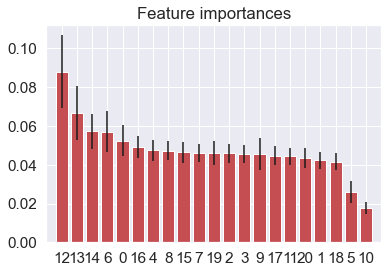

In [28]:
X = X.fillna(0)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

f_list = []
for f in range(X[SELECTED_FEATURE_NAMES].shape[1]):
    f_list.append(indices[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X[SELECTED_FEATURE_NAMES].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X[SELECTED_FEATURE_NAMES].shape[1]])
plt.show()

In [29]:
list(X[SELECTED_FEATURE_NAMES].columns[f_list])

['Composit_3',
 'Composit_4',
 'Composit_5',
 'Current Loan Amount',
 'Annual Income',
 'Composit_7',
 'Maximum Open Credit',
 'Monthly Debt',
 'Composit_6',
 'Current Credit Balance',
 'pca_composit_3',
 'Number of Open Accounts',
 'Years of Credit History',
 'Credit Score',
 'pca_composit_1',
 'Composit_2',
 'pca_composit_4',
 'Years in current job',
 'pca_composit_2',
 'Term',
 'Composit_1']

#### CatBoostClassifier

In [30]:
feature_importances = pd.DataFrame(zip(X[SELECTED_FEATURE_NAMES].columns,
                                       model_cb.feature_importances_ / model_cb.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
6,Current Loan Amount,0.209727
12,Composit_3,0.140758
14,Composit_5,0.095761
13,Composit_4,0.074979
5,Term,0.065567
0,Annual Income,0.057219
16,Composit_7,0.051959
11,Composit_2,0.051517
15,Composit_6,0.040451
4,Maximum Open Credit,0.028129


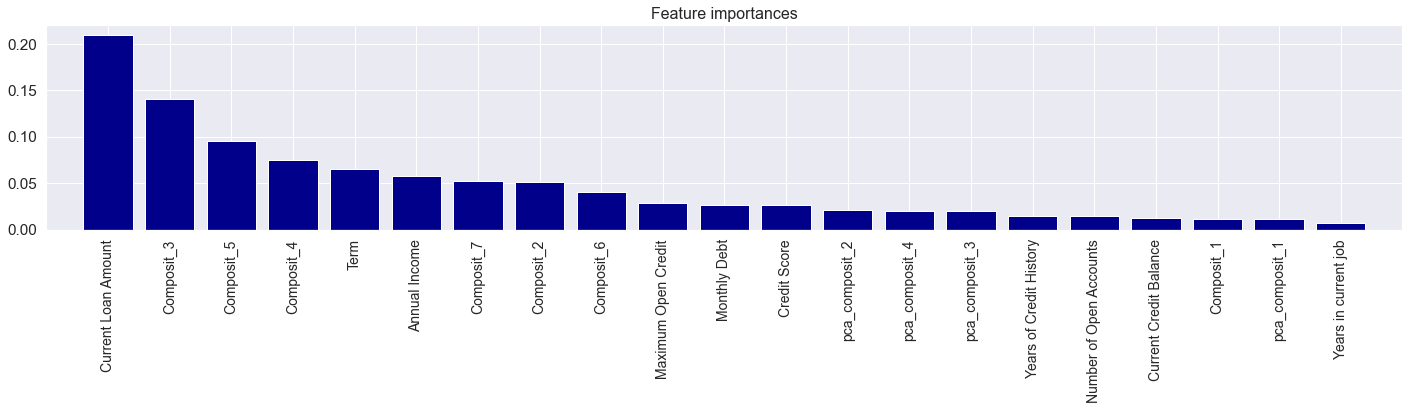

In [31]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model_cb.feature_importances_, X=X_train[SELECTED_FEATURE_NAMES])

## Прогнозирование на тестовом датасете

#### Балансировка классов

In [32]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 5387, 1: 2113})
Resample dataset shape Counter({0: 5387, 1: 5387})


#### Обучение модели на полном наборе данных

In [33]:
model = model.fit(X_ros[SELECTED_FEATURE_NAMES], y_ros)

#### Прогнозирование целевой переменной

In [34]:
y_pred = model.predict(X_final[SELECTED_FEATURE_NAMES].fillna(0))
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final.to_csv(PATH + 'YKutovaya_predictions.csv')
y_final.head()

,Credit Default
0,1
1,1
2,1
3,1
4,1
